In [1]:
import numpy as np
import pandas as pd

from seaborn import despine
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow import keras

from helpers import plotting
from helpers.perceptron import Perceptron

# 1. What to do when data that is not linearly separable?

We have learned that we can use the Perceptron algorithm to build a binary classifier for linearly separable data (by learning a  hyperplane).

Yet, not all data is linearly separable. Take a look at the image below; can you find a straight line that separates the blue and red dots?

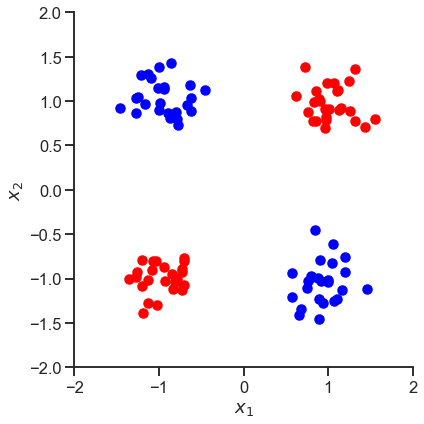

In [2]:
np.random.seed(4128)
# generate clusters
X, y = plotting.generate_not_linearly_separable_clusters()
# plot clusters
fig, ax = plotting.plot_not_linearly_separable_clusters(X, y)
fig.savefig('figures/Figure-9_Not-Linearly-Separable-Data.png', dpi=300)

I don't think it is possible to separate blue and red points with a single straight line.

Yet, the data would be easily separable if we could use two decision boundaries (or one that is curved).

*How do we train a classifier for this problem?*

# 2. XOR with multiple perceptrons

Would it be possible to combine multiple Perceptrons to solve this problem?

We could train one Perceptron to distinguish the red point cloud in the lower left from all others and another  to distinguish the red point cloud in the top right from all others.

A third Perceptron could then use the predictions of the first two to classify the data correctly: if either of the first two Perceptrons predicts that a data point belongs to their target class (so if either predicts $y=1$), the third Perceptron would also predict $y=1$. 

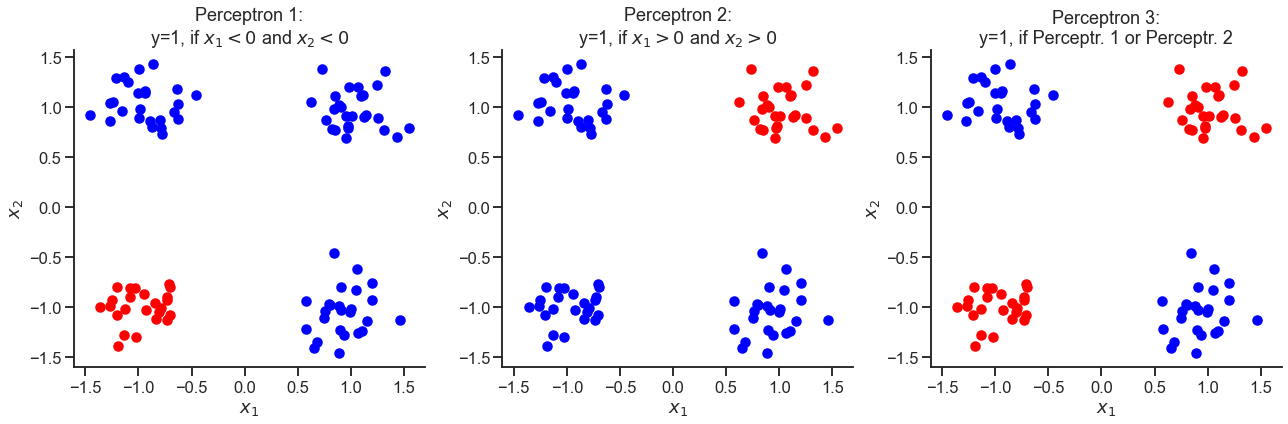

In [3]:
np.random.seed(4128)
fig, axs = plotting.plot_XOR_solution(X, y)
fig.savefig('figures/Figure-10_Multi-Perceptron-Classification.png', dpi=300)

This is a cool idea, let's see if we can get this implemented.

To make the computational setup more clear, take a quick look at the following simple sketch of how the three Perceptrons would work together:

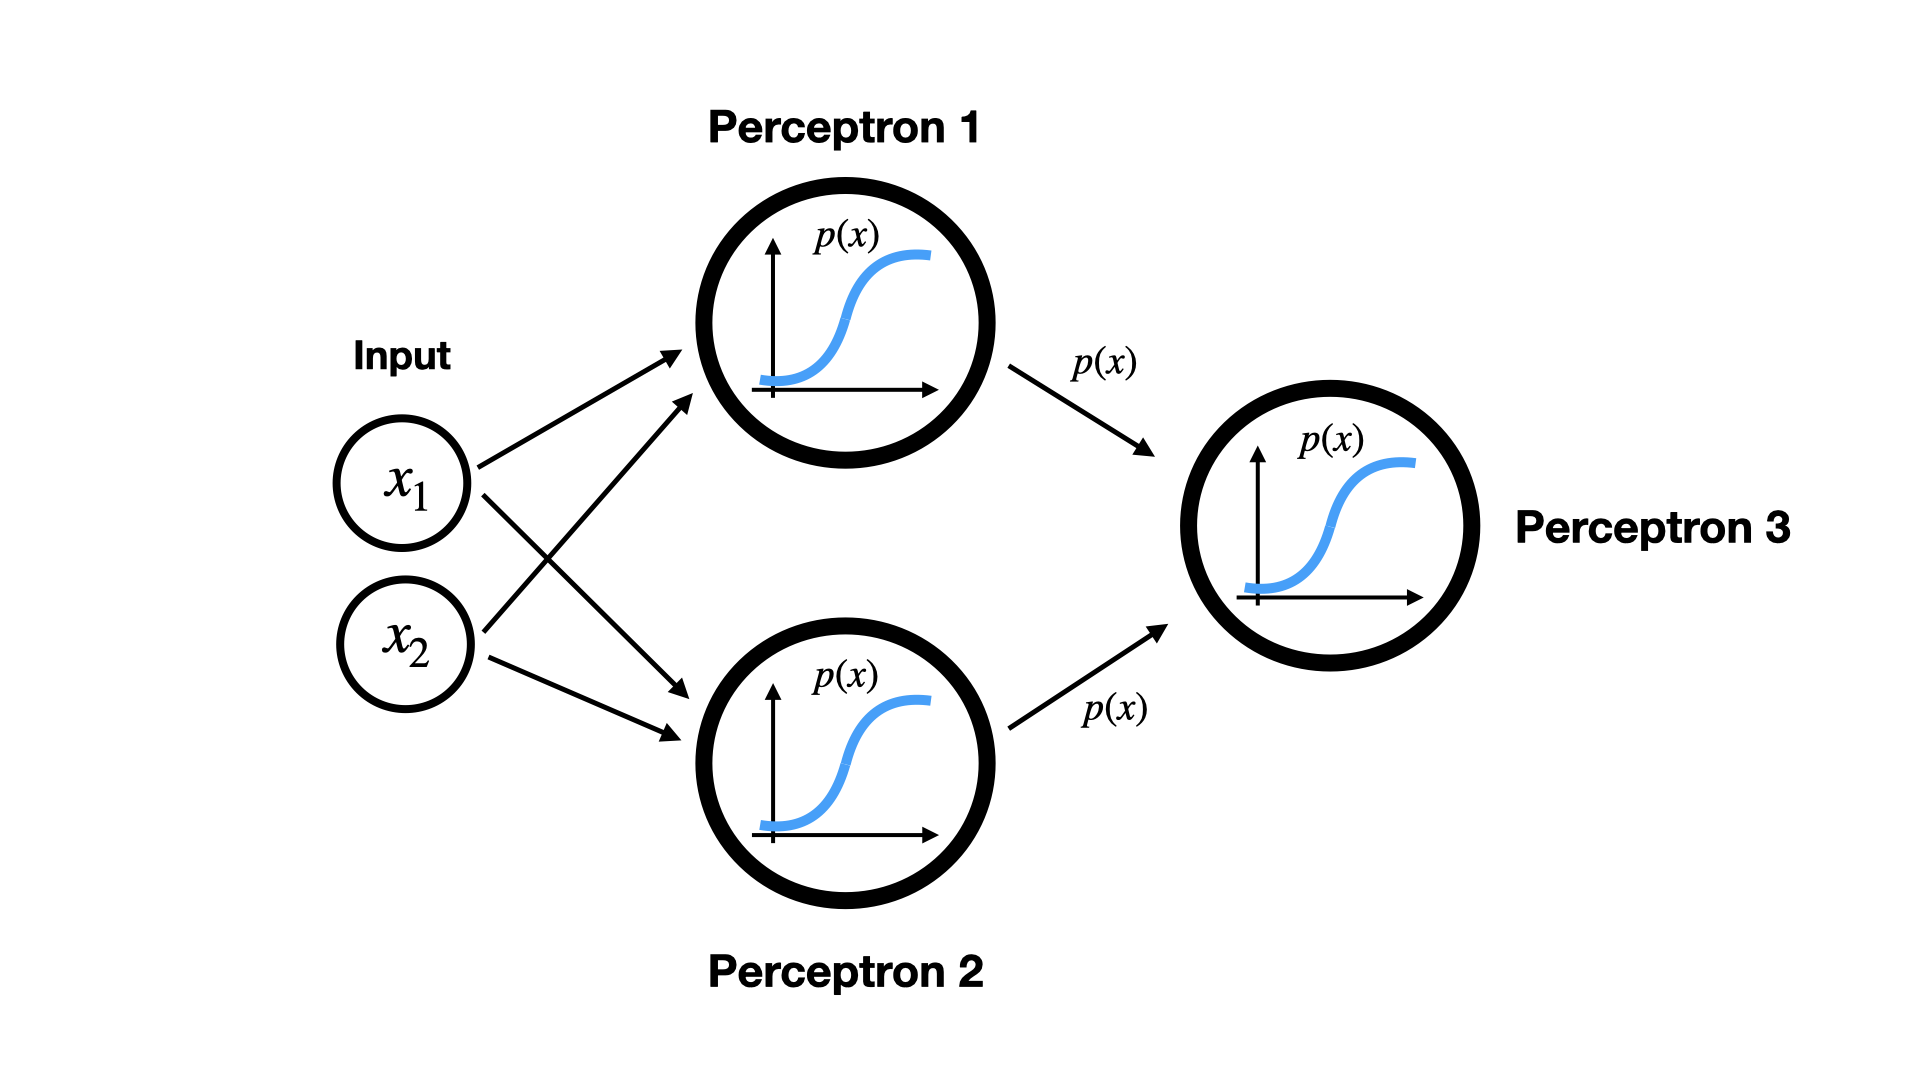

In [4]:
Image(filename='materials/images/Multilayer-Perceptron.png')

Let's train the first Perceptron to distinguish the red point cloud in the lower left from all others (so $y=1$, if $x_1 < 0$ and $x_2 < 0$):

In [5]:
# create new labels
idx1 = np.logical_and(X[:,0]<0, X[:,1]<0)
y1 = idx1.astype(np.int)

# initialize Perceptron
np.random.seed(213)
p1 = Perceptron(n_in=2)

# train
p1.train(X=X, y=y1)

100%|██████████| 100/100 [00:00<00:00, 8988.69it/s]


Now let's do the same for the second Perceptron, which is supposed to distinguish the red point cloud in the top right from all others (so $y=1$, if $x_1 > 0$ and $x_2 > 0$):

In [6]:
# create new labels
idx2 = np.logical_and(X[:,0]>0, X[:,1]>0)
y2 = idx2.astype(np.int)

# initialize Perceptron
np.random.seed(4543)
p2 = Perceptron(n_in=2)

# train
p2.train(X=X, y=y2)

100%|██████████| 100/100 [00:00<00:00, 9004.90it/s]


And now the final step: training a third Perceptron based on the predictions of the first and second Perceptron.

To do this, we combine the predictions of `p1` and `p2` to a new dataset `X3`:

In [7]:
X3 = np.concatenate([p1.predict(X).reshape(-1,1), p2.predict(X).reshape(-1,1)], axis=1)

As we can see, the mean and standard deviation of the two feature colums are now close to 0 and 1.

Remember, the target (`y3`) of our third Percpetron equals 1 if the target of the first or second Perceptron is also 1:

In [8]:
y3 = np.logical_or(y1==1, y2==1).astype(np.int)

We can now train our last Perceptron on this new dataset (`X3`, `y3`):

In [9]:
# initialize Perceptron
np.random.seed(1412)
p3 = Perceptron(n_in=2)
# train
p3.train(X=X3, y=y3)

100%|██████████| 100/100 [00:00<00:00, 7007.21it/s]


Yay; It worked! 

Let's take a quick look at the decision boundaries that each of the Perceptrons has learned:

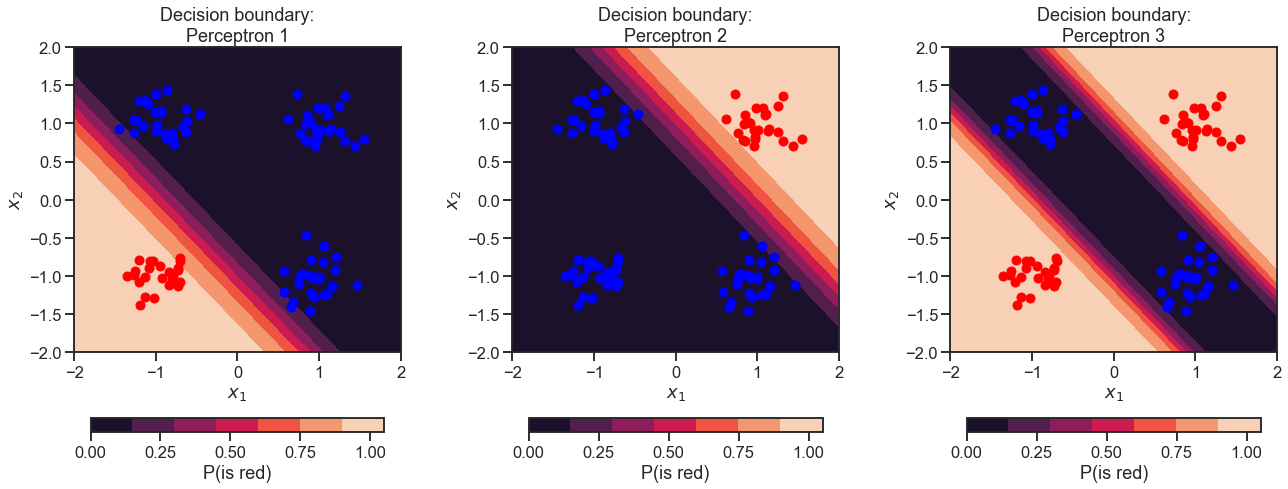

In [10]:
fig, axs = plotting.plot_XOR_decision_boundaries(
    p1=p1, p2=p2, p3=p3, # our three perceptrons
    X=X, # the data
    y1=y1, y2=y2, y3=y3 # the labels of each perceptron
)
fig.savefig('figures/Figure-11_Multi-Perceptron-Decision-Boundaries.png', dpi=300)

Cool!

By combining three individual Perceptrons, we have managed to learn a decision boundary for data that is not linearly separable!

**This idea to sequentially combine multiple simple, but non-linear, functions to a single classifier (or network) forms the basis of deep learning!**

Below, we will explore this idea further.

# 3. Artificial neural networks 

A network of multiple perceptrons (or neurons) that are sequentially combined to form a single predictive system is often called an *artificial neural network* (or ANN).

Note that the individual *Perceptrons* of an artificial neural network are often also called *neurons* (in reference to a biological neural network).

A neural network is formed by combining multiple neurons into a layer and multiple layers to a network.

A standard "dense" neural network consists of the following elements (also see the figure below):

- An *input* layer, representing an instance of the input data (where each feature is represented by a neuron)

- One or multiple *hidden* layer(s), each containing a stack of neurons; Importantly, each neuron receives as input the predictions from all neurons of the preceeding layer (see illustration below)! 

- An *output* layer, containing one output neuron for each target class in the dataset

In the illustration below, the input data is an image of a single handwritten digit; This image has 8x8 pixels.

To serve the image to our ANN, we simply flatten it to be a single vector of 64 values. The input layer therefore has 64 input neurons (one for each of the 64 input features).

As there are 10 unique handwritten digits (0 to 9), we  would further set the output layer to contain 10 neurons (one for each class (or digit)). Each output neuron indicates the probability that the image depicts a digit of its class.

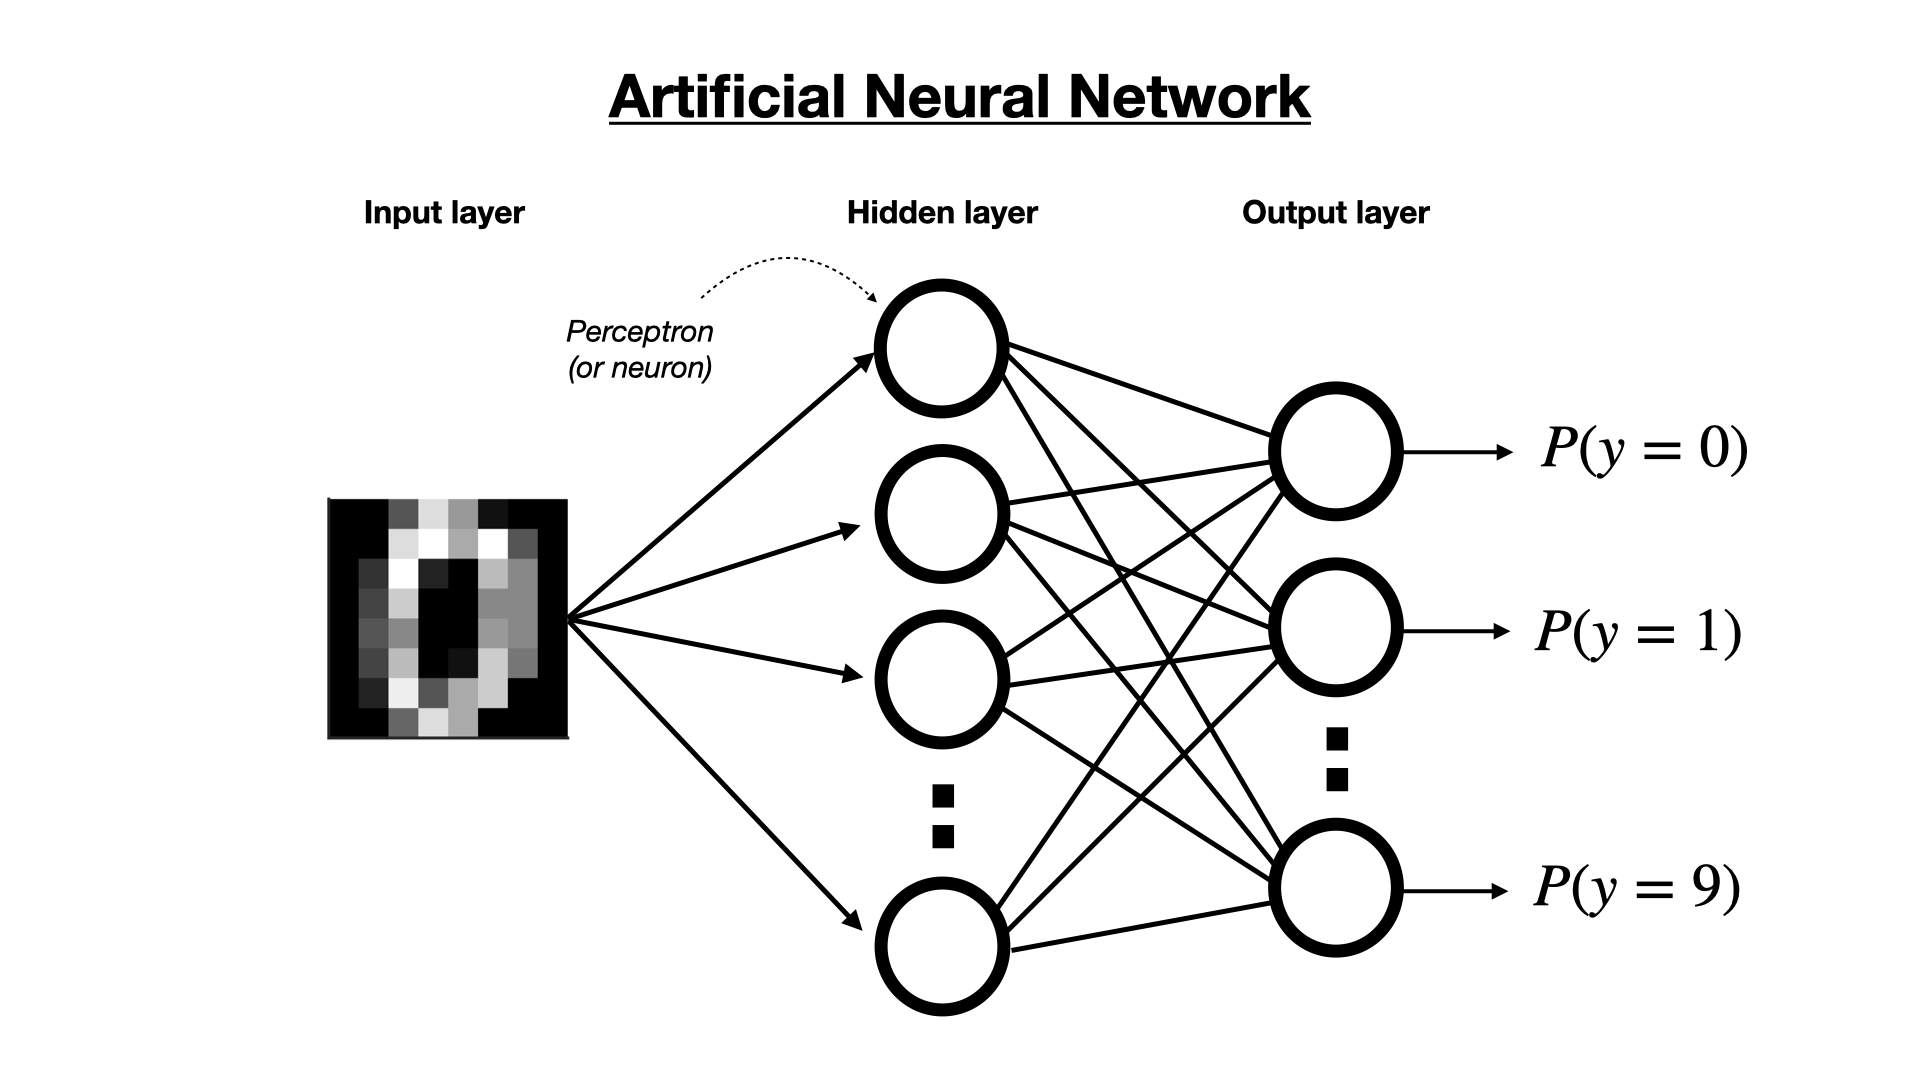

In [11]:
Image(filename='materials/images/Artificial-Neural-Network.png')

In contrast to our previous example (in which we separately trained three individual Perceptrons), an ANN uses linear algebra wizardry to perform all computations in one go.

Specifically, an ANN represents all neurons of a layer as a matrix:

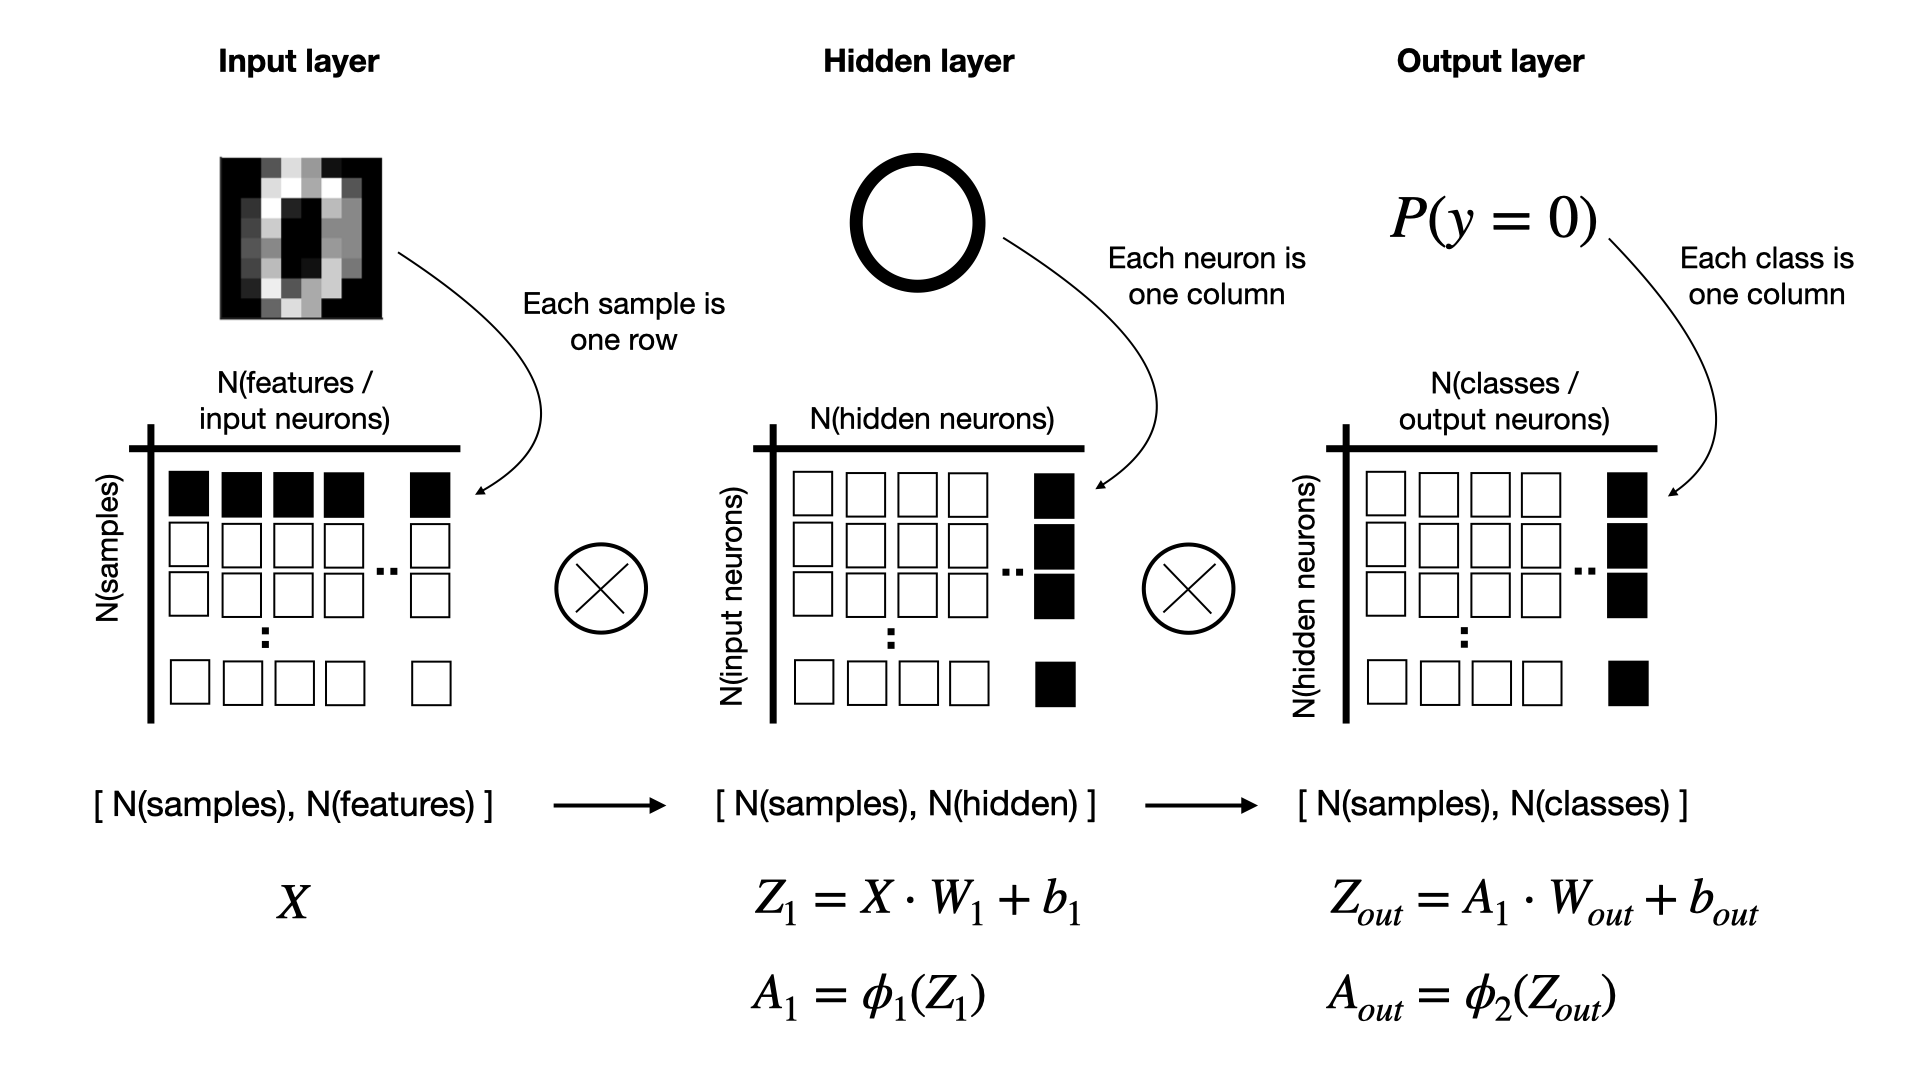

In [12]:
Image(filename='materials/images/ANN-Forward-Pass.png')

## 3.1 Activation functions

Many different types of neuron [activation functions](https://keras.io/api/layers/activations/) $\phi(\cdot)$ have been proposed for different purposes and with different mathematical properties; often designed for numerical stability.

Below, we are taking a quick look at a few of them.

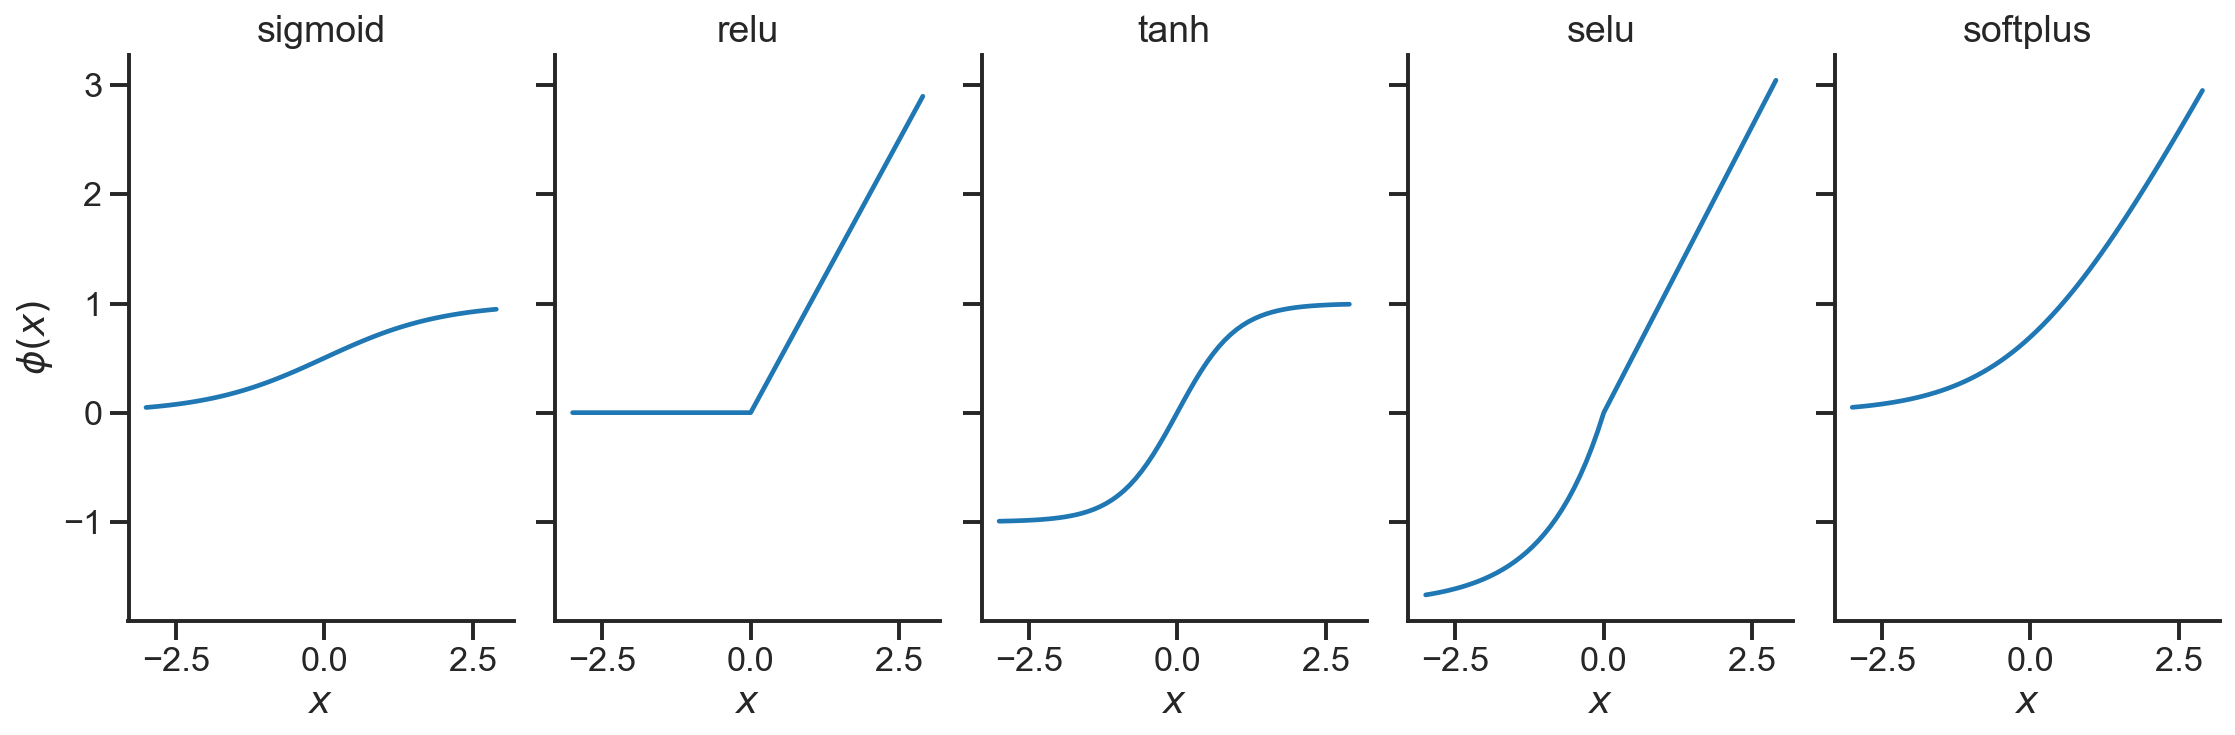

In [13]:
# the list of Keras activation functions that we want to plot (more on Keras later..)
activations = [keras.activations.sigmoid,
               keras.activations.relu,
               keras.activations.tanh,
               keras.activations.selu,
               keras.activations.softplus]
# creating the plot
fig, axs = plotting.plot_keras_activations(activations)
fig.savefig('figures/Figure-12_keras_activations.png', dpi=300)

# 4. Backpropagation

The goal of the [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) algorithm is to enable the application of gradient descent to an ANN; By computing the partial derivative of the loss w.r.t. to each weight of each neuron of the ANN and using the resulting derivatives to update the weights. 

As a reminder, each partial derivative indicates how much the loss function (at its current value) changes with a change in its respective weight.

Conceptually, these derivatives indicate how much each weight contributed to the current value of the loss function (or the current "error"); They are therefore also often referred to as "errors". 

To compute all partial derivatives, the backpropagation algorithm procedes as follows (also see the figure below for a general overview):

1. In a first step, the backpropagation algorithm looks at the prediction $A_{out}$ of the ANN (resulting from a forward pass) and computes the partial derivative of the loss function $L$ w.r.t. the prediction (we will refer to this partial derivative as: $\frac{dL}{dA_{out}}$; It indicates how much the loss function changes with a change in the predictions $A_{out}$). 


2. Subsequently, the backpropagation algorithm looks at the output $Z_{out}$ of the ANN's output layer and estimates how much the prediction $A_{out}$ changes with $Z_{out}$ (by computing the partial derivative $\frac{dA_{out}}{dZ_{out}}$). By the use of this partial derivative, the algorithm can then also obtain the partial derivative of our loss function $L$ w.r.t. the output $Z_{out}$. To do this, it uses the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) and simply multiplies the previously obtained partial derivative $\frac{dL}{dA_{out}}$ with the current partial derivative $\frac{dA_{out}}{dZ_{out}}$: $\frac{dL}{dZ_{out}} = \frac{dA_{out}}{dZ_{out}} \times \frac{dL}{dA_{out}} $ 

    Note that for the combination of sigmoid (or softmax) activation functions and cross-entropy loss this partial derivative breaks down to $\frac{dL}{dZ_{out}} = A_{out} - y$; It is hence often reffered to as the "error signal".


3. Then, the backpropagation algorithm goes back through every hidden layer of the ANN and estimates how much the output $Z_l$ of each layer $l$ has contributed to the current value of the loss function (by computing the partial derivative $\frac{dL}{dZ_l}$ for each layer). By the use of the chain rule, this is simply: $\frac{dL}{dZ_{l-1}} = \frac{dA_{l-1}}{dZ_{l-1}} \times \frac{dZ_{L}}{dA_{l-1}} \times \frac{dL}{dZ_l}$ 


4. For each layer it also computes the partial derivatives of the loss w.r.t. to the weights $W$ of each neuron $\frac{dL}{dW_l}$: $\frac{dL}{dW_{l}} = \frac{dZ_l}{dW_l} \times \frac{dL}{dZ_l}$ (indicating how much the loss function $L$ chanegs w.r.t. the weights $W_l$ of layer $l$). The resulting derivatives are then used to update all ANN weights as follows: $W_l -= \alpha \times \frac{dL}{dW_{l}}$ ($\alpha$ again indicating the learning rate).




For more details on the mechanics of the backpropagation algorithm, please see: 
- https://www.youtube.com/watch?v=Ilg3gGewQ5U&t=387s
- https://www.youtube.com/watch?v=tIeHLnjs5U8&t=353s
- https://www.youtube.com/watch?v=yXcQ4B-YSjQ&t=711s

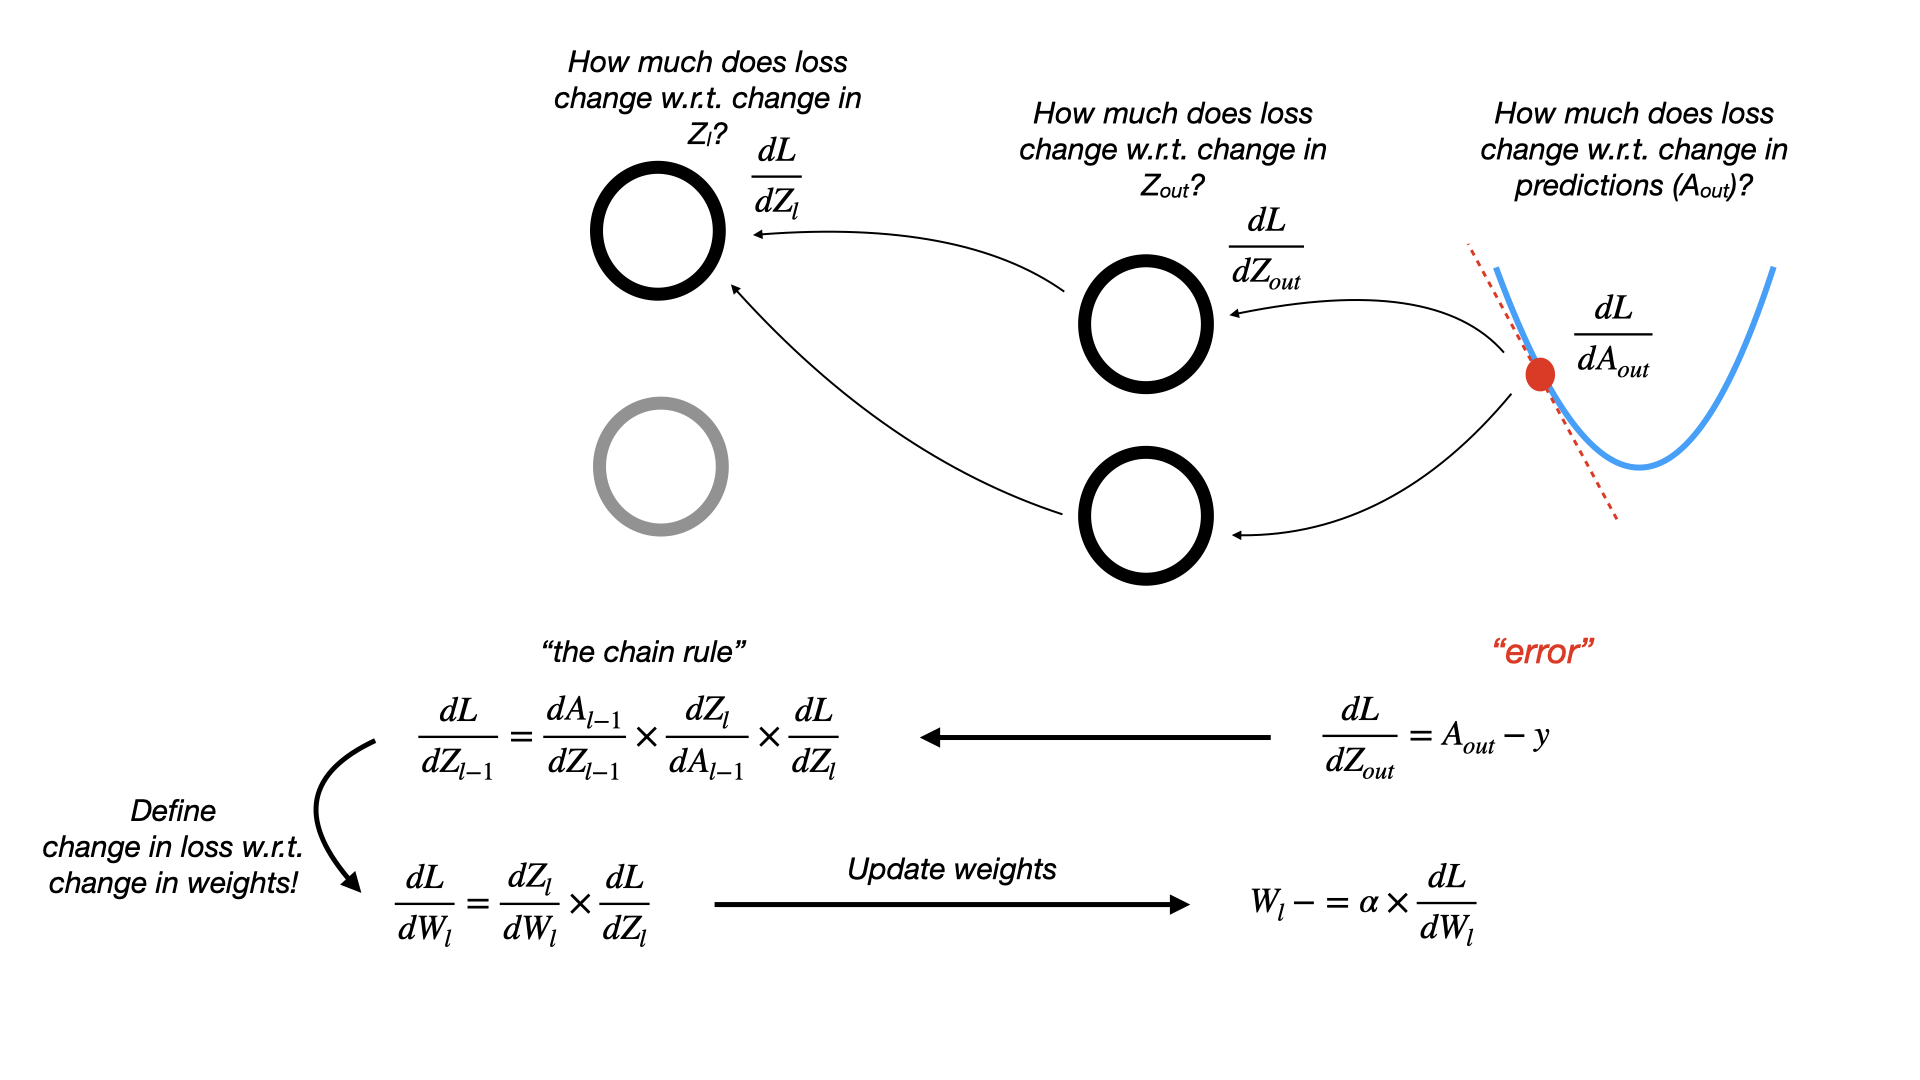

In [14]:
Image(filename='materials/images/Backpropagation.png')

# 5. Your exercise

## 5.1 The CIFAR-10 dataset

The [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) dataset represents a very simple image classification dataset, containing 10 different image categories and 60,000 images (6,000 / class).

We can load the dataset from the [keras](https://keras.io/) library: 

In [15]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

These are the 10 image classes:

In [16]:
cifar_10_classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                             'dog', 'frog', 'horse', 'ship', 'truck'])

In [17]:
print('The dataset contains {} training and {} testing instances'.format(X_train.shape[0], X_test.shape[0]))

The dataset contains 50000 training and 10000 testing instances


Each instance represents a 32 x 32 colored image with three RGB channels:

In [18]:
X_train[0].shape

(32, 32, 3)

Text(0.5, 1.0, 'This is a frog')

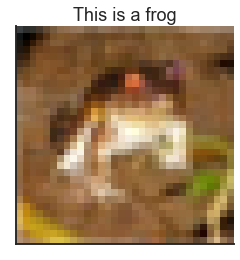

In [19]:
fig, ax = plt.subplots()
ax.imshow(X_train[0])
despine(ax=ax)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('This is a {}'.format(cifar_10_classes[y_train[0][0]]))

## 5.2 Some preprocessing

For simplicity, we convert all images to grayscale:

In [20]:
X_train_gray = (0.21 * X_train[...,0] + 0.72 * X_train[...,1] + 0.07 * X_train[...,2])
X_test_gray = (0.21 * X_test[...,0] + 0.72 * X_test[...,1] + 0.07 * X_test[...,2]).reshape((X_test.shape[0], 32*32))

We then flatten all images:

In [21]:
X_train_flat = X_train_gray.reshape((X_train_gray.shape[0], 32*32))
X_test_flat = X_test_gray.reshape((X_test_gray.shape[0], 32*32))

And standardize each column of our preprocessed dataset (to have a mean of 0 and unit variance):

In [22]:
X_train_stand = (X_train_flat-np.mean(X_train_flat, axis=0)) / np.std(X_train_flat, axis=0)
X_test_stand = (X_test_flat-np.mean(X_test_flat, axis=0)) / np.std(X_test_flat, axis=0)

Let's see how our preprocessed data looks like..

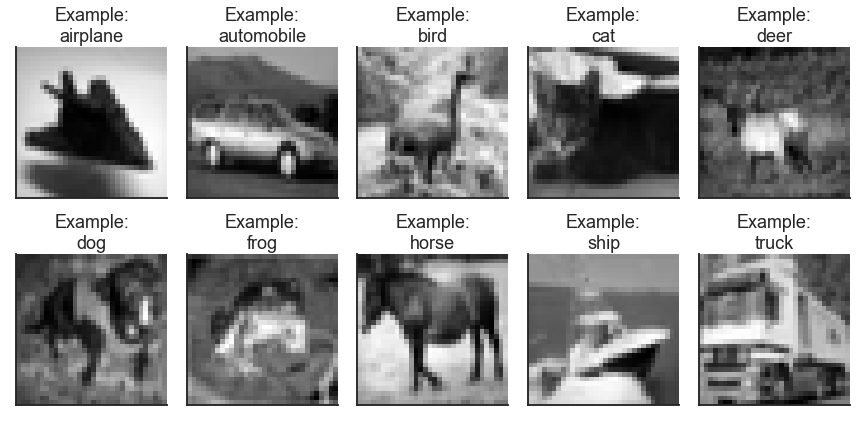

In [23]:
# setup figure
fig, axs = plt.subplots(2,5,figsize=(12,6))
axs = axs.ravel()

# plot 10 examples
for i in range(10):
    idx = np.where(y_train==i)[0][0]
    axs[i].imshow(X_train_stand[idx].reshape((32,32)), cmap='gray')
    axs[i].set_title('Example:\n{}'.format(cifar_10_classes[i]))
    despine(ax=axs[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
fig.tight_layout()

# save
fig.savefig('figures/Figure-13_CIFAR-10-standardized.png', dpi=300)

Seems good--the image categories are still easily recognizable.

## 5.3 Building neural network models with Keras

In this exercise, you will learn how to build neural network models with and [Keras](https://keras.io/about/), which we is part of [Tensorflow](https://www.tensorflow.org/tutorials).

Keras contains a wealth of [standard neural network layers](https://keras.io/api/layers/). 

In this exercise, we will use standard dense layers, which each represent a stack of neurons (as we have discussed earler in this notebook).

To build a neural network, we sequentially define the layers of our model and pass the input through these layers.

Let's take a look at how this works:

In [24]:
# Input layer
inputs = keras.Input(
    shape=(32*32,) # # our data contains 32 x 32 values per instance
) 


# Hidden layer 1:
a1 = keras.layers.Dense(
    units=64, # the first layer that we are adding contains 256 neurons
    activation='relu' # each neuron is activated by a ReLu activation function
)(inputs) # Note that we are also passing the input to this layer!


# Hidden layer 2:
a2 = keras.layers.Dense(
    units=32, # this layer contains 64 neurons
    activation='relu' # each activated with a ReLu function
)(a1) # Note that this time, we are passing the output of the first layer as input to this layer!


# Output layer:
outputs = keras.layers.Dense(
    units=10, # the output layer contains 10 neurons; one for each of the 10 image categories
    activation='softmax' # this time we are using a softmax activation function, to scale the output between 0 and 1
)(a2)

Once our model architecture (or computation graph) is defined, we can complete building the model, by specifying the input and output in the `keras.Model` api:

In [25]:
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar_10_classifer")

To make sure everything worked, lets take a look at `model.summary`:

In [26]:
model.summary()

Model: "cifar_10_classifer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 68,010
Trainable params: 68,010
Non-trainable params: 0
_________________________________________________________________


Looks good :)

## 5.4 Training the network

Before we can train our model, we also need to specify a loss function as well as an optimization algorithm.

This is done by calling `model.compile`:

In [27]:
model.compile(
    
    # define the loss function; We use the cross-entropy loss:
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    
    # as well as the optimizer; We use standard Stochastic Gradient Descent:
    optimizer=keras.optimizers.SGD(),
    
    # We can also specify metrics that should be tracked during training; We use predictive accuracy!
    metrics=["accuracy"])

Now, we are ready to train our model and see how well it performs!

In [28]:
# we also convert our dataset to a tf.Dataset instance,
# to make the training a bit more efficient (this is not necessary though!)
train_dataset = Dataset.from_tensor_slices(
    
    (X_train_stand, y_train) # our X and y data

).shuffle(100).batch(32) # in this step, we also specify that the data should be shuffled during training 
# and that we want batches of 32 instances


# to train our model (thus applying Stochastic Gradient Descent), we call model.fit
history = model.fit(
    
    x=train_dataset, # here, we simply pass our train_dataset as input,
    # which also contains all labels
    
    epochs=20 # we train our neural network model for 20 epochs
    # (each representing an entire iteration over the training data)
)

Epoch 1/20
1563/1563 [==============================] - 1s 805us/step - loss: 1.9982 - accuracy: 0.2893
Epoch 2/20
1563/1563 [==============================] - 1s 846us/step - loss: 1.8262 - accuracy: 0.3529
Epoch 3/20
1563/1563 [==============================] - 1s 758us/step - loss: 1.7547 - accuracy: 0.3804
Epoch 4/20
1563/1563 [==============================] - 1s 761us/step - loss: 1.7042 - accuracy: 0.3994
Epoch 5/20
1563/1563 [==============================] - 1s 804us/step - loss: 1.6649 - accuracy: 0.4139
Epoch 6/20
1563/1563 [==============================] - 1s 805us/step - loss: 1.6323 - accuracy: 0.4253
Epoch 7/20
1563/1563 [==============================] - 1s 908us/step - loss: 1.6032 - accuracy: 0.4351
Epoch 8/20
1563/1563 [==============================] - 1s 791us/step - loss: 1.5779 - accuracy: 0.4436
Epoch 9/20
1563/1563 [==============================] - 1s 919us/step - loss: 1.5571 - accuracy: 0.4507
Epoch 10/20
1563/1563 [==============================] - 1s 947u

Let's see how well our model performs in predicting the labels of the test dataset:

In [29]:
# first, we predict the label of each instance in the test data:
y_pred = model.predict(X_test_stand).argmax(axis=1)

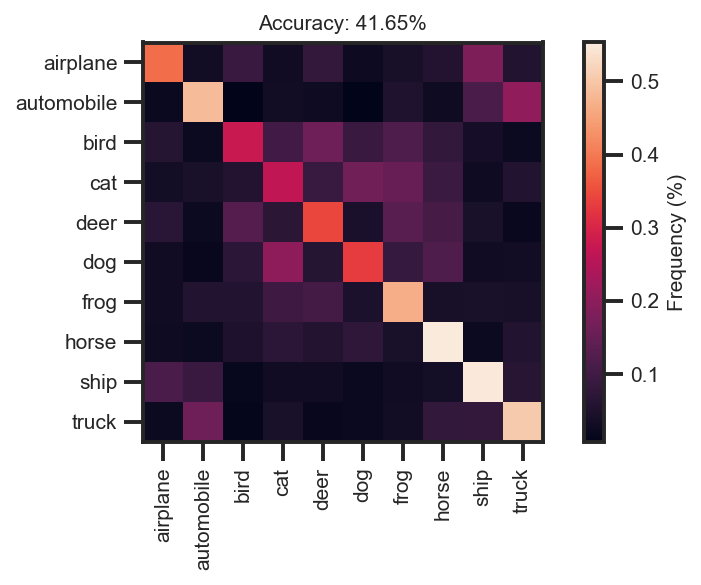

In [30]:
# then we plot the confusion matrix
fig, ax = plotting.plot_confusion_matrix(
    
    y_true=y_test, # the true labels of the test data
    
    y_pred=y_pred, # our predicted labels
    
    y_labels=cifar_10_classes # and the image categories
);
fig.savefig('figures/Figure-14_Our-ANN-performance.png', dpi=300)

## 5.5 Your task:

1. Try to modify the code above and see whether you can outperform our model; vary, for example, the number of layers, the number of neurons per layer, and the number of training epochs

2. How do these changes affect the model performance?